In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns

from time import sleep
from datetime import datetime

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

from pathlib import Path

In [4]:
proj_path = 'drive/MyDrive/MIT!/Classes/6.871/6.871 Project Team Folder/'
eileen_path = proj_path + 'Eileen Data/'
joseph_path = proj_path + 'Joseph Gene Expression Data/'
sina_path = proj_path + 'Sina Data/'

In [ ]:
rna_path = Path(proj_path + 'normalized-rna-data.xlsx')
rna_df = pd.read_excel(rna_path)
rna_df.head()

,Gene,TCGA-4P-AA8J,TCGA-BA-4074,TCGA-BA-4075,TCGA-BA-4076,TCGA-BA-4077,TCGA-BA-4078,TCGA-BA-5149,TCGA-BA-5151,TCGA-BA-5152,TCGA-BA-5153,TCGA-BA-5555,TCGA-BA-5556,TCGA-BA-5557,TCGA-BA-5558,TCGA-BA-5559,TCGA-BA-6868,TCGA-BA-6869,TCGA-BA-6870,TCGA-BA-6871,TCGA-BA-6872,TCGA-BA-6873,TCGA-BA-7269,TCGA-BA-A4IF,TCGA-BA-A4IG,TCGA-BA-A4IH,TCGA-BA-A4II,TCGA-BA-A6D8,TCGA-BA-A6DA,TCGA-BA-A6DB,TCGA-BA-A6DD,TCGA-BA-A6DE,TCGA-BA-A6DG,TCGA-BA-A6DI,TCGA-BA-A6DJ,TCGA-BA-A6DL,TCGA-BA-A8YP,TCGA-BB-4217,TCGA-BB-4223,TCGA-BB-4224,...,TCGA-QK-A8Z8,TCGA-QK-A8Z9,TCGA-QK-A8ZA,TCGA-QK-A8ZB,TCGA-QK-AA3J,TCGA-QK-AA3K,TCGA-RS-A6TO,TCGA-RS-A6TP,TCGA-T2-A6WX,TCGA-T2-A6WZ,TCGA-T2-A6X0,TCGA-T2-A6X2,TCGA-T3-A92M,TCGA-T3-A92N,TCGA-TN-A7HI,TCGA-TN-A7HJ,TCGA-TN-A7HL,TCGA-UF-A718,TCGA-UF-A719,TCGA-UF-A71A,TCGA-UF-A71A.1,TCGA-UF-A71B,TCGA-UF-A71D,TCGA-UF-A71E,TCGA-UF-A7J9,TCGA-UF-A7JA,TCGA-UF-A7JC,TCGA-UF-A7JD,TCGA-UF-A7JF,TCGA-UF-A7JH,TCGA-UF-A7JJ,TCGA-UF-A7JK,TCGA-UF-A7JO,TCGA-UF-A7JS,TCGA-UF-A7JT,TCGA-UF-A7JV,TCGA-UP-A6WW,TCGA-WA-A7GZ,TCGA-WA-A7GZ.1,TCGA-WA-A7H4
0,?|100133144,-2.668367,-0.902774,-0.875868,-0.788130,-0.720443,0.305505,-1.884686,-2.273196,-1.028562,-2.359103,-2.267961,-1.734984,-2.292535,-2.034867,-1.445529,-1.107918,-2.693288,-4.924138,-0.598996,-2.701728,-1.693326,-1.028824,-1.126058,-0.177138,0.555868,-4.038260,-0.418175,-0.350013,-3.113069,-1.636349,-1.669245,-1.396426,-0.250961,-0.698789,-1.235164,-1.715348,-2.172558,0.692689,-0.759041,...,-3.655830,-2.671399,-1.226739,0.080303,0.097108,-2.735148,-0.282547,0.766106,-0.510861,0.365926,-0.063281,-0.349853,-1.191962,-1.413758,-2.039966,0.450061,-2.250369,-0.576201,-0.892550,0.412633,-0.375885,-0.002416,0.012172,-0.885552,0.107522,0.186019,0.248591,-0.595343,-1.099779,-0.509501,-1.487508,0.784834,-1.195505,-2.153869,-2.552769,-2.570372,-0.957308,1.103520,1.055458,0.110682
1,?|100134869,-0.794596,-1.020686,-2.464098,-2.221278,-0.817997,-0.380211,-1.300005,-2.467344,-2.103687,-1.200386,-2.639825,-1.386775,-1.542003,-0.099920,-1.203517,-0.184573,-2.223283,-1.524609,0.511413,-1.497810,-0.519020,-2.926866,0.069059,-0.617449,0.294437,-1.599741,-1.268774,-2.703403,-1.258081,-1.987165,-2.019275,-4.073444,-0.064970,-1.485542,-1.667472,-0.351495,-1.863715,0.325171,-1.096923,...,-2.005872,-1.121858,-0.589878,0.244041,0.619169,-1.347078,-1.228849,1.150059,-0.165324,-1.335510,1.230945,0.076515,-0.698765,-0.998200,-1.801836,0.926873,-1.446833,-0.321043,-0.846905,1.036154,-0.526208,-0.385914,-1.147425,-0.536055,0.258005,0.332227,0.173918,-1.749557,-0.305143,-1.010059,-0.272792,0.844650,-1.583013,-2.747920,-3.398868,-0.710990,-0.290401,1.118641,0.730860,0.065397
2,?|10357,2.411792,3.752946,3.888404,3.634904,3.915315,3.313590,3.563117,2.727658,2.735800,3.036732,2.753468,2.934567,2.452501,3.283812,3.655104,3.285483,1.962820,2.940204,3.198316,2.351329,3.338756,1.387340,4.097065,3.339682,3.665524,2.800231,1.799342,0.556048,2.536214,2.694082,2.321353,2.114732,2.570874,2.725813,2.521753,3.613625,4.021507,3.273238,3.727679,...,2.515806,1.929937,3.203928,1.798339,3.225687,2.533997,0.494128,3.026564,2.555471,1.452136,2.279025,2.184747,3.471884,3.265413,2.644048,2.297885,2.424818,1.051801,2.293206,4.051905,3.576949,2.762821,1.628951,2.265648,2.014319,2.358678,1.522075,2.625551,2.010490,2.429561,1.744007,2.406473,3.157449,-0.420827,2.519974,2.545822,2.312506,1.767151,2.989047,2.724889
3,?|10431,5.945483,6.270801,5.988357,5.749688,5.322637,5.071589,5.728863,6.196538,5.694105,5.245816,4.967065,5.191896,4.908296,5.308824,5.207073,5.195706,5.975070,5.399957,5.708008,5.480605,5.582467,6.821470,6.130176,5.893784,5.690444,5.834212,6.357782,5.306547,5.648564,6.023422,6.712605,5.167052,5.104636,5.603932,6.236621,4.851152,5.798102,5.261801,6.403219,...,5.758368,5.037845,5.685049,5.487995,5.533157,5.522161,5.838139,5.418221,5.614866,6.652706,5.481120,5.563760,5.564250,5.871047,6.304907,5.586194,5.982780,4.730400,5.587638,5.466640,5.384323,5.269697,6.112797,5.679450,5.477513,5.304144,6.047472,5.436376,5.963395,5.358525,4.973021,5.648660

In [ ]:
mut_clean_path = Path(eileen_path + 'rna&mut_data_top_400.csv')
mut_df = pd.read_csv(mut_clean_path)
mut_df = mut_df[mut_df.Consequence.apply(lambda x: 'synonymous_variant' not in x)]
mut_df = mut_df[mut_df['rank'] > 60]
mut_df.tail()

,Unnamed: 0,PATIENT_ID,binary_vital_status,survival_days,age_at_diagnosis,Matched_Norm_Sample_Barcode,gene,rank,Entrez_Gene_Id,Matched_Norm_Sample_Barcode.1,Tumor_Sample_Barcode,Consequence,rna_seq_count
4048,4048,TCGA-IQ-7632,0,441.945,68,TCGA-IQ-7632-10,TRIM27,300,5987.0,TCGA-IQ-7632-10,TCGA-IQ-7632-01,missense_variant,4.809671
4049,4049,TCGA-IQ-7632,0,441.945,68,TCGA-IQ-7632-10,PAX5,314,5079.0,TCGA-IQ-7632-10,TCGA-IQ-7632-01,missense_variant,0.444092
4050,4050,TCGA-IQ-7632,0,441.945,68,TCGA-IQ-7632-10,PCDH11X,317,27328.0,TCGA-IQ-7632-10,TCGA-IQ-7632-01,missense_variant,-4.595420
4051,4051,TCGA-IQ-7632,0,441.945,68,TCGA-IQ-7632-10,BRWD3,355,254065.0,TCGA-IQ-7632-10,TCGA-IQ-7632-01,missense_variant,2.332453
4053,4053,TCGA-CV-6433,0,642.330,57,TCGA-CV-6433-11,TAF1,361,6872.0,TCGA-CV-6433-11,TCGA-CV-6433-01,missense_variant,4.616759


# Mutational Data

## Eileen Data Processing

In [ ]:
one_hot_genes = pd.get_dummies(mut_df['gene'])
one_hot_data = mut_df[['PATIENT_ID','binary_vital_status', 'survival_days']].join(one_hot_genes)
patient_ids = one_hot_data.PATIENT_ID.unique()
metadata = one_hot_data[['PATIENT_ID','binary_vital_status', 'survival_days']].drop_duplicates().reset_index().drop(columns='index')

dfs_to_append = [] 

for id in patient_ids: 
  rel_col = one_hot_data[one_hot_data.PATIENT_ID == id]
  mut = rel_col.drop(columns=['PATIENT_ID','binary_vital_status', 'survival_days'])
  summed_df = mut.sum().apply(lambda x: 0 if x == 0 else 1)
  dfs_to_append.append(summed_df)

combined_df = pd.concat(dfs_to_append, axis=1).T
final_mut_df = metadata.join(combined_df)
final_mut_df.head()

,PATIENT_ID,binary_vital_status,survival_days,ABCB9,ACSS3,ADAMTS3,ADCY10,ADRBK2,AHNAK,AHSG,AK5,ALDH1A2,AMY2B,ANKH,APAF1,ASPA,ASXL3,ATP1B3,BBX,BICC1,BMP2K,BRIP1,BRWD3,BTNL8,C19orf18,C1QTNF3,C2orf88,C4orf33,C7orf60,C8orf34,C8orf76,CADPS2,CAPS2,CCDC7,CCL1,CCND1,CD40,CDH8,CDK8,CECR2,...,THAP2,THAP5,THSD7A,TIGD4,TMEM167A,TMEM2,TMEM200A,TMTC3,TNFRSF11A,TRAT1,TRIM27,TRIM58,TSGA10,TWSG1,UFSP1,UPF2,UVRAG,VEZF1,WARS2,YIPF7,YOD1,ZBTB22,ZFP2,ZFP36L2,ZFP42,ZFP91,ZNF10,ZNF211,ZNF254,ZNF285,ZNF383,ZNF491,ZNF568,ZNF623,ZNF684,ZNF701,ZNF763,ZNF846,ZNF98,ZRANB2
0,TCGA-CV-5971,0,702.415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TCGA-CV-A468,1,464.820,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,TCGA-F7-A624,0,378.810,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0
3,TCGA-BA-A6D8,0,851.560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TCGA-CV-7424,1,453.840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Models

**Binary Classification** 

In [ ]:
X, y = final_mut_df.drop(columns=['PATIENT_ID','binary_vital_status', 'survival_days']), final_mut_df['binary_vital_status']

clf = RandomForestClassifier()
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5029920212765957
LR 0.48470875052148515


Linear Regression

In [ ]:
X_lreg, y_lreg = final_mut_df.drop(columns=['PATIENT_ID', 'binary_vital_status', 'survival_days']), final_mut_df['survival_days']
lreg = LinearRegression()
cv_results = cross_validate(lreg, X_lreg, y_lreg, cv=5, return_train_score = True)
print("LinReg", np.mean(cv_results['test_score']))

LinReg -2.2683284066581046e+26


# RNA Data

## Load

### Hide Old

In [ ]:
# # Open normalized data
# df = rna_df

# genes = df[['Gene']]
# features = df[df.columns[1:]].T

# # Get Labels
# judith_path = Path(proj_path + "/ITH-H_N_Judith.xlsx")
# judith_df = pd.read_excel(judith_path)

# # All Patients
# patients_df = judith_df[['PATIENT_ID', 'survival_days', 'binary_vital_status']]

# #Filter out patients NOT IN RNA NORMED DATA ONLY
# for pat in ['TCGA-MT-A67G', 'TCGA-CQ-7064', 'TCGA-IQ-A61L', 'TCGA-CN-A63Y', 'TCGA-BA-A6DF', 'TCGA-IQ-A61K', 'TCGA-CN-A640']:
#   patients_df = patients_df.loc[patients_df['PATIENT_ID'] != pat, ('PATIENT_ID', 'survival_days', 'binary_vital_status')]



### New

In [ ]:
df = rna_df

clean_path = Path(eileen_path + "cleaned_clinical_data.csv")
clean_df = pd.read_csv(clean_path)

patients_df = clean_df[['PATIENT_ID', 'OS_MONTHS', 'BINARY_SURVIVAL']]
patients_df = patients_df[~patients_df.PATIENT_ID.isin( ['TCGA-MT-A67G', 'TCGA-CQ-7064', 'TCGA-IQ-A61L', 'TCGA-CN-A63Y', 'TCGA-BA-A6DF', 'TCGA-IQ-A61K', 'TCGA-CN-A640'])]

In [ ]:
rna_var = Path(joseph_path + "variation.csv")
rna_var_genes = pd.read_csv(rna_var)
rna_var_genes = rna_var_genes.iloc[:25,1]
rna_exp_df = df[df.Gene.isin(rna_var_genes)]

In [ ]:
rna_var_genes


0            MYH2|4620
1            MYH1|4619
2            MYL1|4632
3      C20orf114|92747
4          MAGEA6|4105
            ...       
995           HLF|3131
996        HOXA11|3207
997     C14orf73|91828
998         MPPED2|744
999      PCDHGB1|56104
Name: Gene, Length: 1000, dtype: object

In [ ]:
# Get rna norm data as features, survival days as labels
patients_rna = X = rna_exp_df[patients_df.PATIENT_ID].T #Uses top k genes
patients_vital = y = patients_df['BINARY_SURVIVAL']

pats_df = patients_df[~patients_df.PATIENT_ID.isin(['TCGA-CQ-A4CA','TCGA-H7-A6C4'])]
X_lreg = rna_exp_df[pats_df.PATIENT_ID].T
patients_survival = y_lreg = pats_df['OS_MONTHS']

In [ ]:
X_p = X_lreg
y_p = pd.to_numeric(pats_df['OS_MONTHS']).apply(lambda x: 1 if x >= 36 else 0)

## Models

In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, X_p, y_p, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, class_weight='balanced')
cv_results = cross_validate(clf, X_p, y_p, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.44936124794745486
LR 0.4617766830870279


In [ ]:
model_params = {
    "penalty":["l1","l2", "elasticnet", "none"],
    "C":[0.1, 0.25, 0.5, 1, 5, 10],
    "solver":["liblinear", "lbfgs", "saga", "sag"]
}

search_model = GridSearchCV(LogisticRegression(), model_params)
search_model.fit(X_p, y_p)
search_model.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mode

{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

**Binary Classification**

In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='saga', C=0.25, class_weight='balanced')
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5487929292929292
LR 0.6067239057239058


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

**Results** \\
**RFC | LR**

400: \\
60 | 56

200: \\
62 | 59

100: \\
59 | 61 or
61 | 61

50: \\
60 | 61

25: \\
56 | 62

10: \\
52 | 57

**OLD** \\
All Genes: \\
RFC 62 \\
LR 60

400 Genes: \\
RFC 61 \\
LR 54

200 Genes:
RFC 63 \\
LR 59

100 Genes: \\
RFC 61 \\
LR 63

50 Genes: \\
RFC 59 \\
LR 61

**Linear Regression**

In [ ]:
lreg = LinearRegression()
cv_results = cross_validate(lreg, X_lreg, y_lreg, cv=5, return_train_score = True)
print("LinReg", np.mean(cv_results['test_score']))

LinReg -0.22412631642163516


**NEW**

400: -56.6

200: -1.97

100: -0.71

50: -0.37

25: -0.22

10: -0.22

**OLD**

All genes:
-0.31

400 Genes:
-14.17

200 Genes:
-2.76

100 Genes:
-0.925

50 Genes:
-0.376

# Methylation Data

## Load Data

In [ ]:
#df = rna_df

clean_path = Path(eileen_path + "cleaned_clinical_data.csv")
clean_df = pd.read_csv(clean_path)
patients_df = clean_df[['PATIENT_ID', 'OS_MONTHS', 'BINARY_SURVIVAL']]

meth_path = Path(sina_path + "top1000var_meth.csv")
meth_df = pd.read_csv(meth_path)
meth_df.head()

,Unnamed: 0,Hugo_Symbol,Entrez_Gene_Id,variation,TCGA-4P-AA8J-01,TCGA-BA-4074-01,TCGA-BA-4075-01,TCGA-BA-4076-01,TCGA-BA-4077-01,TCGA-BA-4078-01,TCGA-BA-5149-01,TCGA-BA-5151-01,TCGA-BA-5152-01,TCGA-BA-5153-01,TCGA-BA-5555-01,TCGA-BA-5556-01,TCGA-BA-5557-01,TCGA-BA-5558-01,TCGA-BA-5559-01,TCGA-BA-6868-01,TCGA-BA-6869-01,TCGA-BA-6870-01,TCGA-BA-6871-01,TCGA-BA-6872-01,TCGA-BA-6873-01,TCGA-BA-7269-01,TCGA-BA-A4IF-01,TCGA-BA-A4IG-01,TCGA-BA-A4IH-01,TCGA-BA-A4II-01,TCGA-BA-A6D8-01,TCGA-BA-A6DA-01,TCGA-BA-A6DB-01,TCGA-BA-A6DD-01,TCGA-BA-A6DE-01,TCGA-BA-A6DF-01,TCGA-BA-A6DG-01,TCGA-BA-A6DI-01,TCGA-BA-A6DJ-01,TCGA-BA-A6DL-01,...,TCGA-QK-A8Z7-01,TCGA-QK-A8Z8-01,TCGA-QK-A8Z9-01,TCGA-QK-A8ZA-01,TCGA-QK-A8ZB-01,TCGA-QK-AA3J-01,TCGA-QK-AA3K-01,TCGA-RS-A6TO-01,TCGA-RS-A6TP-01,TCGA-T2-A6WX-01,TCGA-T2-A6WZ-01,TCGA-T2-A6X0-01,TCGA-T2-A6X2-01,TCGA-T3-A92M-01,TCGA-T3-A92N-01,TCGA-TN-A7HI-01,TCGA-TN-A7HJ-01,TCGA-TN-A7HL-01,TCGA-UF-A718-01,TCGA-UF-A719-01,TCGA-UF-A71A-06,TCGA-UF-A71A-01,TCGA-UF-A71B-01,TCGA-UF-A71D-01,TCGA-UF-A71E-01,TCGA-UF-A7J9-01,TCGA-UF-A7JA-01,TCGA-UF-A7JC-01,TCGA-UF-A7JD-01,TCGA-UF-A7JF-01,TCGA-UF-A7JH-01,TCGA-UF-A7JJ-01,TCGA-UF-A7JK-01,TCGA-UF-A7JO-01,TCGA-UF-A7JS-01,TCGA-UF-A7JT-01,TCGA-UF-A7JV-01,TCGA-UP-A6WW-01,TCGA-WA-A7GZ-01,TCGA-WA-A7H4-01
0,14686,GSTM1,2944.0,0.119655,0.036893,0.031900,0.178476,0.937528,0.884739,0.185403,0.063763,0.829054,0.151500,0.927675,0.898993,0.025696,0.067859,0.692876,0.724886,0.144395,0.259713,0.287737,0.349038,0.324864,0.923756,0.705415,0.766223,0.743542,0.903797,0.709285,0.178395,0.870161,0.613987,0.062842,0.047501,0.088807,0.042666,0.616226,0.880707,0.799584,...,0.108018,0.051122,0.120006,0.119649,0.052534,0.147349,0.055442,0.029364,0.119017,0.125712,0.064903,0.151956,0.113249,0.077113,0.836390,0.163229,0.659147,0.085788,0.042273,0.264163,0.887039,0.721269,0.056660,0.023511,0.121055,0.111313,0.561632,0.067609,0.030788,0.139835,0.079715,0.704300,0.126556,0.818535,0.854941,0.137747,0.767590,0.153425,0.356625,0.036943
1,2347,MYH14,79784.0,0.099371,0.186882,0.751656,0.857746,0.934318,0.091442,0.061266,0.803596,0.683065,0.673634,0.089523,0.116807,0.732102,0.528028,0.834650,0.392971,0.365760,0.077893,0.397707,0.783098,0.874083,0.820718,0.063372,0.217599,0.155897,0.106839,0.322337,0.075381,0.493337,0.612363,0.526420,0.904590,0.828589,0.670581,0.582012,0.909510,0.769562,...,0.072353,0.083179,0.812575,0.585740,0.359282,0.071034,0.510412,0.772016,0.061551,0.893538,0.620299,0.109100,0.866219,0.595384,0.915419,0.101443,0.659007,0.468878,0.144673,0.111141,0.084168,0.061907,0.893554,0.489704,0.438504,0.069853,0.335069,0.894962,0.193605,0.090313,0.073892,0.589182,0.897440,0.896961,0.826484,0.806370,0.351661,0.713009,0.820614,0.200124
2,9037,AEBP1,165.0,0.084202,0.022080,0.266477,0.750876,0.900528,0.028733,0.019199,0.711596,0.569134,0.678753,0.019379,0.033204,0.496102,0.505320,0.587426,0.312002,0.595097,0.050103,0.614568,0.497328,0.250098,0.472463,0.016287,0.030045,0.040408,0.020750,0.027558,0.019972,0.605917,0.032864,0.230782,0.032584,0.690168,0.313193,0.078228,0.701594,0.024534,...,0.018786,0.027948,0.661648,0.019157,0.029847,0.063333,0.019280,0.535348,0.019841,0.664825,0.705036,0.067354,0.763147,0.026202,0.784555,0.023009,0.649773,0.021435,0.519956,0.021525,0.024487,0.027272,0.226416,0.752458,0.813727,0.023402,0.018830,0.834155,0.030919,0.240368,0.022070,0.387631,0.681383,0.573266,0.725304,0.591735,0.480374,0.031688,0.702227,0.426351
3,1800,WWOX,51741.0,0.084108,0.876060,0.340502,0.569547,0.941361,0.190372,0.151340,0.610040,0.947681,0.850265,0.301977,0.235201,0.945708,0.887447,0.939635,0.259108,0.120829,0.712123,0.900227,0.087304,0.911047,0.902415,0.220637,0.775412,0.732739,0.106195,0.875589,0.847699,0.894700,0.941389,0.888654,0.907597,0.927428,0.908435,0.741015,0.939456,0.958829,...,0.844879,0.105583,0.875782,0.754929,0.272306,0.075514,0.537663,0.854144,0.935852,0.950850,0.955799,0.527957,0.932417,0.824920,0.802431,0.830407,0.613233,0.374753,0.950802,0.509344,0.620985,0.885983,0.693862,0.406001,0.9060

In [ ]:
meth_var_genes = meth_df.iloc[:400,1]
meth_proc_df = meth_df[meth_df.Hugo_Symbol.isin(meth_var_genes)]
meth_proc_df = meth_proc_df.fillna(0)

X = meth_proc_df[[pat + "-01" for pat in patients_df.PATIENT_ID]].T
y = patients_df['BINARY_SURVIVAL']


In [ ]:
### Survival Months Not Available for these two patients ####
pats_df = patients_df[~patients_df.PATIENT_ID.isin(['TCGA-CQ-A4CA','TCGA-H7-A6C4'])]
X_lreg = meth_proc_df[[pat + "-01" for pat in pats_df.PATIENT_ID]].T
patients_survival = y_lreg = pats_df['OS_MONTHS']

## Models

**Binary Classification**

In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5910281503560192
LR 0.5809606446983496


**Results**

400: \\
59 | 57 or 59 | 58

200: \\
56 | 55

100: \\
57 | 58 or 59 | 58

50: \\
60 | 56

25: \\
57 | 54

10: \\
53 | 52


**Linear Regression**

In [ ]:
lreg = LinearRegression()
cv_results = cross_validate(lreg, X_lreg, y_lreg, cv=5, return_train_score = True)
print("LinReg", np.mean(cv_results['test_score']))z

LinReg -0.13311600494873105


** *italicized text*Results**
400: -139.7 \\
200: -1.93 \\
100: -0.66 \\
50: -0.30 \\
25: -0.17 \\
10: -0.13 \\

# Meth and RNA overlap

## Load

In [19]:
clean_path = Path(eileen_path + "cleaned_clinical_data.csv")
clean_df = pd.read_csv(clean_path)

patients_df = clean_df[['PATIENT_ID', 'OS_MONTHS', 'BINARY_SURVIVAL']]
patients_df = patients_df[~patients_df.PATIENT_ID.isin( ['TCGA-MT-A67G', 'TCGA-CQ-7064', 'TCGA-IQ-A61L', 'TCGA-CN-A63Y', 'TCGA-BA-A6DF', 'TCGA-IQ-A61K', 'TCGA-CN-A640'])]

rna_path = Path(proj_path + 'normalized-rna-data.xlsx')
rna_df = pd.read_excel(rna_path)

meth_path = Path(sina_path + "top1000var_meth.csv")
meth_df = pd.read_csv(meth_path)
meth_df = meth_df.fillna(0)


genes_path = Path(sina_path + "overlap_sina_joseph.csv")
genes_df = pd.read_csv(genes_path)
genes_df.head()

,Unnamed: 0,gene
0,0,CLDN17
1,1,ALX1
2,2,MRAP2
3,3,LOC254559
4,4,SLC13A5


In [20]:
rna_df

,Gene,TCGA-4P-AA8J,TCGA-BA-4074,TCGA-BA-4075,TCGA-BA-4076,TCGA-BA-4077,TCGA-BA-4078,TCGA-BA-5149,TCGA-BA-5151,TCGA-BA-5152,TCGA-BA-5153,TCGA-BA-5555,TCGA-BA-5556,TCGA-BA-5557,TCGA-BA-5558,TCGA-BA-5559,TCGA-BA-6868,TCGA-BA-6869,TCGA-BA-6870,TCGA-BA-6871,TCGA-BA-6872,TCGA-BA-6873,TCGA-BA-7269,TCGA-BA-A4IF,TCGA-BA-A4IG,TCGA-BA-A4IH,TCGA-BA-A4II,TCGA-BA-A6D8,TCGA-BA-A6DA,TCGA-BA-A6DB,TCGA-BA-A6DD,TCGA-BA-A6DE,TCGA-BA-A6DG,TCGA-BA-A6DI,TCGA-BA-A6DJ,TCGA-BA-A6DL,TCGA-BA-A8YP,TCGA-BB-4217,TCGA-BB-4223,TCGA-BB-4224,...,TCGA-QK-A8Z8,TCGA-QK-A8Z9,TCGA-QK-A8ZA,TCGA-QK-A8ZB,TCGA-QK-AA3J,TCGA-QK-AA3K,TCGA-RS-A6TO,TCGA-RS-A6TP,TCGA-T2-A6WX,TCGA-T2-A6WZ,TCGA-T2-A6X0,TCGA-T2-A6X2,TCGA-T3-A92M,TCGA-T3-A92N,TCGA-TN-A7HI,TCGA-TN-A7HJ,TCGA-TN-A7HL,TCGA-UF-A718,TCGA-UF-A719,TCGA-UF-A71A,TCGA-UF-A71A.1,TCGA-UF-A71B,TCGA-UF-A71D,TCGA-UF-A71E,TCGA-UF-A7J9,TCGA-UF-A7JA,TCGA-UF-A7JC,TCGA-UF-A7JD,TCGA-UF-A7JF,TCGA-UF-A7JH,TCGA-UF-A7JJ,TCGA-UF-A7JK,TCGA-UF-A7JO,TCGA-UF-A7JS,TCGA-UF-A7JT,TCGA-UF-A7JV,TCGA-UP-A6WW,TCGA-WA-A7GZ,TCGA-WA-A7GZ.1,TCGA-WA-A7H4
0,?|100133144,-2.668367,-0.902774,-0.875868,-0.788130,-0.720443,0.305505,-1.884686,-2.273196,-1.028562,-2.359103,-2.267961,-1.734984,-2.292535,-2.034867,-1.445529,-1.107918,-2.693288,-4.924138,-0.598996,-2.701728,-1.693326,-1.028824,-1.126058,-0.177138,0.555868,-4.038260,-0.418175,-0.350013,-3.113069,-1.636349,-1.669245,-1.396426,-0.250961,-0.698789,-1.235164,-1.715348,-2.172558,0.692689,-0.759041,...,-3.655830,-2.671399,-1.226739,0.080303,0.097108,-2.735148,-0.282547,0.766106,-0.510861,0.365926,-0.063281,-0.349853,-1.191962,-1.413758,-2.039966,0.450061,-2.250369,-0.576201,-0.892550,0.412633,-0.375885,-0.002416,0.012172,-0.885552,0.107522,0.186019,0.248591,-0.595343,-1.099779,-0.509501,-1.487508,0.784834,-1.195505,-2.153869,-2.552769,-2.570372,-0.957308,1.103520,1.055458,0.110682
1,?|100134869,-0.794596,-1.020686,-2.464098,-2.221278,-0.817997,-0.380211,-1.300005,-2.467344,-2.103687,-1.200386,-2.639825,-1.386775,-1.542003,-0.099920,-1.203517,-0.184573,-2.223283,-1.524609,0.511413,-1.497810,-0.519020,-2.926866,0.069059,-0.617449,0.294437,-1.599741,-1.268774,-2.703403,-1.258081,-1.987165,-2.019275,-4.073444,-0.064970,-1.485542,-1.667472,-0.351495,-1.863715,0.325171,-1.096923,...,-2.005872,-1.121858,-0.589878,0.244041,0.619169,-1.347078,-1.228849,1.150059,-0.165324,-1.335510,1.230945,0.076515,-0.698765,-0.998200,-1.801836,0.926873,-1.446833,-0.321043,-0.846905,1.036154,-0.526208,-0.385914,-1.147425,-0.536055,0.258005,0.332227,0.173918,-1.749557,-0.305143,-1.010059,-0.272792,0.844650,-1.583013,-2.747920,-3.398868,-0.710990,-0.290401,1.118641,0.730860,0.065397
2,?|10357,2.411792,3.752946,3.888404,3.634904,3.915315,3.313590,3.563117,2.727658,2.735800,3.036732,2.753468,2.934567,2.452501,3.283812,3.655104,3.285483,1.962820,2.940204,3.198316,2.351329,3.338756,1.387340,4.097065,3.339682,3.665524,2.800231,1.799342,0.556048,2.536214,2.694082,2.321353,2.114732,2.570874,2.725813,2.521753,3.613625,4.021507,3.273238,3.727679,...,2.515806,1.929937,3.203928,1.798339,3.225687,2.533997,0.494128,3.026564,2.555471,1.452136,2.279025,2.184747,3.471884,3.265413,2.644048,2.297885,2.424818,1.051801,2.293206,4.051905,3.576949,2.762821,1.628951,2.265648,2.014319,2.358678,1.522075,2.625551,2.010490,2.429561,1.744007,2.406473,3.157449,-0.420827,2.519974,2.545822,2.312506,1.767151,2.989047,2.724889
3,?|10431,5.945483,6.270801,5.988357,5.749688,5.322637,5.071589,5.728863,6.196538,5.694105,5.245816,4.967065,5.191896,4.908296,5.308824,5.207073,5.195706,5.975070,5.399957,5.708008,5.480605,5.582467,6.821470,6.130176,5.893784,5.690444,5.834212,6.357782,5.306547,5.648564,6.023422,6.712605,5.167052,5.104636,5.603932,6.236621,4.851152,5.798102,5.261801,6.403219,...,5.758368,5.037845,5.685049,5.487995,5.533157,5.522161,5.838139,5.418221,5.614866,6.652706,5.481120,5.563760,5.564250,5.871047,6.304907,5.586194,5.982780,4.730400,5.587638,5.466640,5.384323,5.269697,6.112797,5.679450,5.477513,5.304144,6.047472,5.436376,5.963395,5.358525,4.973021,5.648660

In [109]:
# hugo = lambda x : x.split("|")[0]
# genes = genes_df.gene.str.replace(r'[a-z]+|[a-z]+', hugo)

rna_overlap = rna_df[rna_df['Gene'].apply(lambda g: any([str(x) ==  g.split("|")[0] for x in genes_df.gene.values]))]
meth_overlap = meth_df[meth_df.Hugo_Symbol.isin(genes_df.gene)]

In [111]:
pats_rna = rna_overlap[patients_df.PATIENT_ID]
pats_meth = meth_overlap[[pat + "-01" for pat in patients_df.PATIENT_ID]]
new_names = {x: y for x, y in zip(pats_meth.columns, pats_rna.columns)}
X = pd.concat([pats_rna, pats_meth.rename(columns=new_names)], ignore_index=True)
X = X.T
y = patients_df['BINARY_SURVIVAL']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219
TCGA-4P-AA8J,1.557654,2.147765,-2.268722,3.113584,2.671448,0.542092,5.766262,1.321528,-0.288921,2.867989,-3.743013,-1.162944,-0.385739,4.346536,-0.336518,2.464821,-5.535868,-1.939864,-0.787300,2.584665,-1.939864,-1.554947,1.012886,-0.198186,-3.304006,6.315385,0.404096,-4.377273,3.712660,2.873229,-2.268722,3.825877,2.485500,3.468942,-1.079588,-2.470606,-1.000774,2.002293,2.584665,-0.436708,...,0.824512,0.078068,0.356636,0.686795,0.772182,0.842397,0.109853,0.899376,0.885238,0.749016,0.577863,0.441398,0.045949,0.697315,0.805008,0.273417,0.810487,0.672974,0.625042,0.573931,0.022781,0.616018,0.730767,0.901373,0.119325,0.042243,0.479445,0.021783,0.823219,0.034057,0.632986,0.184937,0.715685,0.690234,0.100887,0.720547,0.457601,0.391490,0.813552,0.185931
TCGA-BA-4074,0.117535,1.213815,-4.817821,-1.195265,-1.747521,-1.824292,3.170226,5.251076,-1.991297,-5.642222,-4.296485,2.742117,0.700464,-0.960526,-1.195265,1.561811,-5.642222,0.780414,4.567379,-1.195265,3.362160,2.700833,1.406199,-4.296485,-1.145159,5.101272,3.206857,-0.615369,4.190978,0.362338,-3.150472,9.093775,2.367126,1.771981,-5.642222,-1.923850,-5.642222,2.731328,4.419159,0.462685,...,0.343530,0.625043,0.754377,0.461467,0.575118,0.297663,0.208854,0.564968,0.465423,0.435238,0.253425,0.563785,0.437677,0.543199,0.721728,0.557288,0.547947,0.362120,0.220177,0.627820,0.023367,0.232283,0.391456,0.395695,0.563010,0.032956,0.319221,0.031235,0.863994,0.032398,0.365447,0.528380,0.322625,0.879799,0.517337,0.411522,0.382505,0.331764,0.765983,0.203692
TCGA-BA-4076,-3.434160,0.488682,-5.486715,-3.108814,3.913738,-0.561437,-2.843505,4.284498,0.604249,1.211595,-5.486715,4.035935,-3.854912,5.829639,-4.451513,-1.027992,-1.614575,-0.465075,6.228113,3.579973,-0.775936,-0.960734,-2.836226,-2.425595,-5.486715,5.605955,-2.254729,-3.854912,5.240703,3.078593,-3.854912,6.130280,2.706804,4.334391,0.690466,-4.429438,-0.331613,-0.374740,4.066647,-1.250926,...,0.974058,0.144655,0.760847,0.953548,0.935956,0.935991,0.061421,0.940074,0.934582,0.768129,0.611844,0.835582,0.025003,0.935789,0.888934,0.150080,0.589548,0.871340,0.767691,0.163818,0.019472,0.443519,0.431055,0.914077,0.145124,0.062896,0.897556,0.018016,0.858426,0.020677,0.920255,0.611491,0.720849,0.936966,0.045591,0.270206,0.356397,0.731391,0.759805,0.780626
TCGA-BA-4078,-0.700590,2.450555,-4.700674,-1.046276,-0.300482,-3.950647,-1.936023,1.228382,2.613955,1.059160,2.598423,4.057931,-2.452676,-3.950647,-1.085882,5.322391,-0.064620,-0.188475,5.985567,-0.447491,3.764990,1.453779,-0.157340,0.221531,1.796368,1.368443,1.604447,-2.259176,5.018453,-0.188475,4.043723,-1.556392,0.664949,-0.167077,2.404855,-1.729361,-1.672196,4.313825,-2.010289,-2.802493,...,0.861729,0.082795,0.899534,0.386581,0.922714,0.943590,0.034701,0.407754,0.316825,0.893290,0.889760,0.626806,0.027019,0.552585,0.143877,0.191715,0.929874,0.266408,0.710635,0.889777,0.017942,0.630519,0.652138,0.938323,0.178727,0.057087,0.864553,0.015648,0.210194,0.016601,0.913071,0.659434,0.446729,0.833059,0.095818,0.888664,0.837036,0.862937,0.412536,0.126813
TCGA-BA-5149,-4.261041,-3.894903,-2.533619,-2.971457,6.199639,-2.665319,3.118804,4.845919,-3.152900,-2.665319,-5.505319,-2.810261,-3.152900,4.992434,-4.753085,-4.261041,-2.665319,-2.301554,3.444500,-0.786947,-1.926212,-5.505319,-3.114762,-5.505319,-5.505319,5.614153,-1.500081,-3.603130,6.413931,-0.987867,-4.753085,6.747706,-2.011288,0.524562,-2.533619,-5.505319,-2.101724,-0.087393,-2.412943,1.419082,...,0.718630,0.446445,0.630731,0.845140,0.309942,0.801773,0.279054,0.884827,0.875000,0.531096,0.245380,0.631518,0.050744,0.863449,0.808881,0.436152,0.558456,0.452838,0.741747,0.762071,0.035764,0.275109,0.561434,0.919388,0.130744,0.438465,0.489331,0.204130,0.719062,0.033603,0.690240,0.644358,0

In [ ]:
pats_df = patients_df[~patients_df.PATIENT_ID.isin(['TCGA-CQ-A4CA','TCGA-H7-A6C4'])]
pats_rna_lin = rna_overlap[pats_df.PATIENT_ID]
pats_meth_lin = meth_overlap[[pat + "-01" for pat in pats_df.PATIENT_ID]]
new_names_lin = {x: y for x, y in zip(pats_meth.columns, pats_rna.columns)}
X_lreg = pd.concat([pats_rna_lin, pats_meth_lin.rename(columns=new_names_lin)], ignore_index=True)
X_lreg = X_lreg.T
y_lreg = pats_df['OS_MONTHS']

## Models

In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5870563973063974
LR 0.6134461279461279


RFC: 0.59 \\
LR: 0.61 

Comp: \\
RFC : Meth 56 | RNA 62 | Overlap 59 \\
LR: Meth 55 | RNA 59 | Overlap 61

In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, pats_rna.T, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, pats_rna.T, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5937037037037036
LR 0.6138265993265992


RNA OG: 59 | 61 or 61 | 61 \\
RNA New: 59 | 61


In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, pats_meth.T, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, pats_meth.T, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5657651515151515
LR 0.5776818181818182


Meth OG: 57 | 58 or 59 | 58 \\
Meth New: 56 | 58

In [ ]:
lreg = LinearRegression()
cv_results = cross_validate(lreg, X_lreg, y_lreg, cv=5, return_train_score = True)
print("LinReg", np.mean(cv_results['test_score']))

LinReg -2.3077217441524756


-2.31

# $R^{2}$ Plot

##Load Counts

In [1]:
#Path to merged mut count
mut_count_path = Path(eileen_path + "merged_mut-count.csv")
merged_df = pd.read_csv(mut_count_path)

#Drop bad vals
merged_df['mutation_count'].replace('[Not Available]', np.nan, inplace=True)
merged_df['OS_MONTHS'].replace('[Not Available]', np.nan, inplace=True)
merged_df = merged_df.dropna(subset=['mutation_count', 'OS_MONTHS'])

#Get Rows
mut_counts = merged_df['mutation_count']
survival = merged_df['OS_MONTHS']

NameError: ignored

## Calculate and Plot

Text(0.5, 1.0, 'r^2 = 0.00039844884338078814')

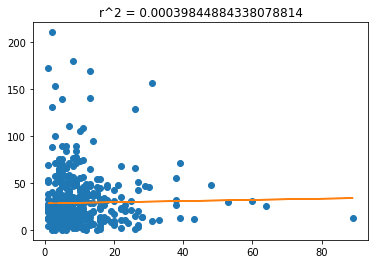

In [ ]:
X = pd.to_numeric(mut_counts)
y = pd.to_numeric(survival)

corr_mat = np.corrcoef(X,y)
r = corr_mat[0,1]
r_sq = r**2

m, b = np.polyfit(X, y, 1)

plt.plot(X, y, 'o')
plt.plot(X, m*X + b)
plt.title("r^2 = " + str(r_sq))

# CBIO

## Load

In [ ]:
merged_path = Path(eileen_path + "merged_mut-count.csv")
merged_df = pd.read_csv(merged_path)

patients_df = merged_df[['PATIENT_ID', 'OS_MONTHS', 'BINARY_SURVIVAL']]
smol_cbio_df = merged_df[['PATIENT_ID',	'SEX',	'AGE',	'PRIMARY_SITE_PATIENT',	'RACE',	'SMOKING_PACK_YEARS',	'CLIN_N_STAGE',	'CLIN_T_STAGE',	'CLIN_M_STAGE',	'CLINICAL_STAGE',	'OS_MONTHS',	'BINARY_SURVIVAL', 'HPV_STATUS']]

# for col in smol_cbio_df.columns:
#   if type(smol_cbio_df[col][0]) != str: continue 
#   if any(~smol_cbio_df[col].str.contains("[Not Available]")):
#     print(col)

AGE
RACE
SMOKING_PACK_YEARS
CLIN_T_STAGE
CLIN_M_STAGE
OS_MONTHS


In [ ]:
one_hot_feats = [ 'PRIMARY_SITE_PATIENT', 'SEX', 'RACE', 'CLINICAL_STAGE']
one_hots = smol_cbio_df[one_hot_feats]
one_hots = pd.get_dummies(one_hots)

In [ ]:
num_df = smol_cbio_df[["AGE", "SMOKING_PACK_YEARS"]].replace('[Not Available]', np.nan)
num_df = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='median').fit(num_df).transform(num_df), columns=['AGE', 'SMOKING_PACK_YEARS'])

In [ ]:
X = pd.concat([one_hots, num_df, smol_cbio_df[['HPV_STATUS']]], axis = 1) #pd.concat([one_hots, conts], axis=1)
y = smol_cbio_df['BINARY_SURVIVAL']

## Model 

In [ ]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization
clf = LogisticRegression(penalty="l1", solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5225429292929293
LR 0.5516683501683501


RFC: 0.51-0.54 \\
LR: 0.54

Without Race: \\
RFC - 0.53 \\
LR - 0.551

Without Sex: \\
RFC - 0.53
LR - 0.551

Without Race & Sex: \\
RFC - 0.53 \\
LR - 0.551

# Microenv

In [77]:
judith_path = Path(eileen_path + "relevant_judith.csv")
judith_df = pd.read_csv(judith_path)
judith_df.drop(columns='Unnamed: 0', inplace=True)
judith_df = judith_df.replace('[Not Available]', np.nan)

merged_path = Path(eileen_path + "merged_mut-count.csv")
merged_df = pd.read_csv(merged_path)

judith_df = judith_df[judith_df.PATIENT_ID.isin(merged_df.PATIENT_ID)]
patients_df = merged_df[merged_df.PATIENT_ID.isin(judith_df.PATIENT_ID)][['PATIENT_ID', 'BINARY_SURVIVAL']]

In [78]:
patients_df = patients_df.sort_values("PATIENT_ID")
judith_df = judith_df.sort_values("PATIENT_ID")
judith_df = judith_df.drop(columns="PATIENT_ID")


features = pd.DataFrame(SimpleImputer(missing_values=np.nan, strategy='median').fit(judith_df).transform(judith_df)) 


In [107]:
X, y = features, patients_df['BINARY_SURVIVAL']


In [108]:
clf = RandomForestClassifier()
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("RFC", np.mean(cv_results['test_score']))

#try l1 regularization 
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, class_weight='balanced')
cv_results = cross_validate(clf, X, y, cv=5, scoring='roc_auc')
print("LR", np.mean(cv_results['test_score']))

RFC 0.5934449155037391
LR 0.6082321574968634


Microenv: \\
RFC - 0.59 \\
LR - 0.61